In [1]:
import sys
import subprocess
import json
import gzip
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib import transforms


sys.path.append(os.path.abspath("../generation"))
import generate
from parseRePEAT import *

In [2]:
def plot_atf(segments, label, color='red', x_min=0):
    line = None
    for (x0, x1, y0, y1) in segments:
        if x0 == "-inf" and x1 != "inf" and y1 != "inf":
            plt.hlines(float(y1), x_min, float(x1), colors=color)
        line, = plt.plot([float(x0), float(x1)], [float(y0), float(y1)], color=color)
    line.set_label(label) if line is not None else None

def generate_intervals(max_delay, layout, scenario, agent, agent_speed, move):
    # Generate intervals
    generate.time_safe_intervals_and_write(layout, scenario, agent["trainNumber"], agent_speed, "output", max_delay)
    start = "r-n1_2" if agent["trainNumber"] == 2 else "r-n1_1"
    try:
        proc = subprocess.run(["atsipp.exe", "--start", start, "--goal", "r-14", "--edgegraph", "output", "--search", "repeat", "--startTime", str(move["startTime"])], timeout=60, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    except subprocess.TimeoutExpired:
        print(f'Timeout for repeat (60s) expired')
    repeat_output = str(proc.stdout).split("'")[1].rsplit("\\r\\n")

    # If the run was successful
    if int(proc.returncode) == 0:
        metadata, catf, paths, eatfs = parse_list_of_outputs(repeat_output)
        print(catf)
        color = "blue" if max_delay > 0 else "red"
        label = f"{max_delay}s buffer time" if max_delay > 0 else "No flexibility"
        plot_atf(catf, label, color, move["startTime"])

[('-inf', '100', '675.688', '675.688'), ('100', '432.385', '675.688', '1008.07'), ('432.385', '552.385', '1008.07', '1128.07'), ('552.385', '1251.18', '1826.87', '1826.87'), ('1251.18', '1832.39', '1826.87', '2408.07'), ('1832.39', '1952.39', '2408.07', '2528.07'), ('1952.39', 'inf', 'inf', 'inf')]


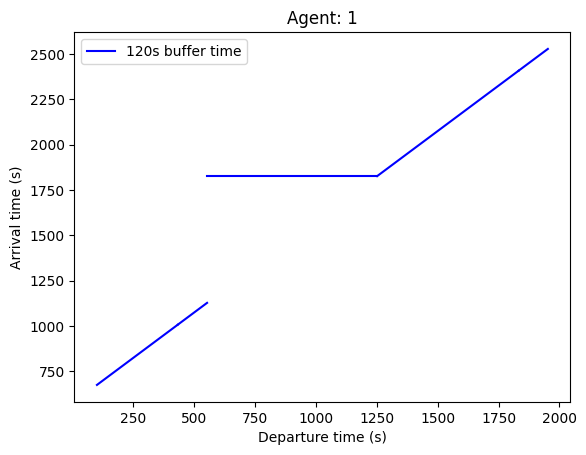

[('-inf', '400', '1551.38', '1551.38'), ('400', '1296.12', '1551.38', '2447.5'), ('1296.12', '1386.62', '2447.5', '2537.99'), ('1386.62', '1416.12', '2537.99', '2567.5'), ('1416.12', '1897.77', '3049.15', '3049.15'), ('1897.77', '1970', '3049.15', '3121.38'), ('1970', '2017.77', '3169.15', '3169.15'), ('2017.77', '2090', '3169.15', '3241.38'), ('2090', '2123', '3274.38', '3274.38'), ('2123', '2848.62', '3274.38', '4000'), ('2848.62', '2940.37', '4000', '4091.74'), ('2940.37', '2968.62', '4091.74', '4120'), ('2968.62', 'inf', 'inf', 'inf')]


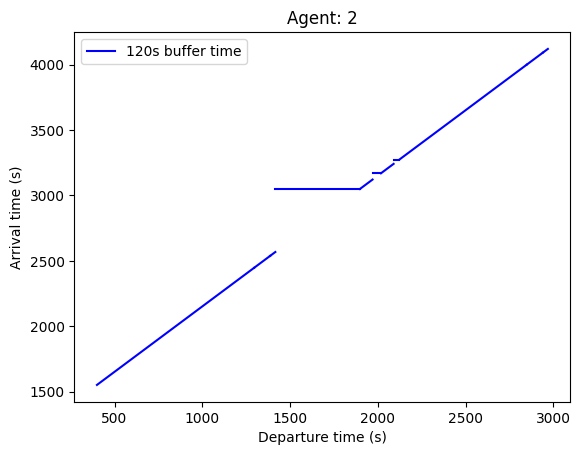

[('-inf', '1900', '2475.69', '2475.69'), ('1900', '3424.31', '2475.69', '4000'), ('3424.31', '3470.18', '4000', '4045.87'), ('3470.18', '3540.14', '4045.87', '4115.83'), ('3540.14', '3544.31', '4115.83', '4120'), ('3544.31', 'inf', 'inf', 'inf')]


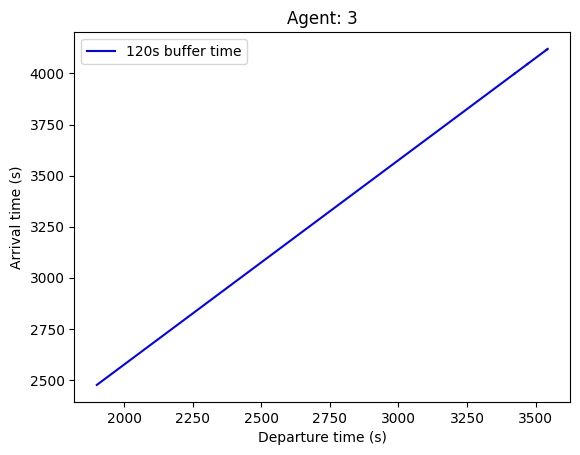

In [5]:
# Run RePeAT to get multiple plans
scenario = "../data/single_track/scenario_following.json"
layout =   "../data/single_track/woho.json"

scenario_data = json.load(open(scenario))
train_types = {x["name"]: x for x in scenario_data["types"]}
for agent in scenario_data['trains']:
    # Get the global end time of scenario
    scenario_end_time = 0
    for i in range(len(agent["movements"])):
        move = agent["movements"][i]
        if 2 * move["endTime"] > scenario_end_time:
            scenario_end_time = 2 * move["endTime"]
    agent_speed = train_types[agent["trainUnitTypes"][0]]["speed"] * 1.09
    # agent_speed = 60
    for move in agent["movements"]:
        # Difference
        generate_intervals(120, layout, scenario, agent, agent_speed, move)

        # baseline
        # generate_intervals(0,   layout, scenario, agent, agent_speed, move)

        title = f"Agent: {agent['trainNumber']}"
        plt.xlabel("Departure time (s)")
        plt.ylabel("Arrival time (s)")
        plt.title(title)
        plt.legend()
        plt.show()

